# Bayesian neural network

First, we load the modules we need:

In [1]:
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from coinem.model import AbstractModel
from coinem.dataset import Dataset

# Pyplot for plots.
import matplotlib.pyplot as plt 

from jax import vmap

from bnn import BNN

NameError: name 'AbstractModel' is not defined

In [5]:
from coinem.uci import Boston#, Concrete, Energy, Kin8nm, Naval, Power

data = Boston()
data.name()


'Boston'

We can now run the algorithms using an 80/20 training/test split of the data:

In [11]:
import jax.tree_util as jtu
# Set approximation parameters:
h = 1e-1 # Step-size. 
K = 1000  # Number of steps.
N = 10  # Number of particles.

key = jr.PRNGKey(42)

model = BNN(
    num_datapoints=data.X.shape[0],
    feature_dim=data.X.shape[1],
    num_hidden=50,
)

latent, theta = model.init_params(N)

In [67]:
# Learning rates:
theta_step_sizes = jnp.logspace(-10, 2, num=100)
latent_step_sizes = jnp.logspace(-10, 2, num=100)

In [75]:
from coinem.zoo import coin_svgd, adam_svgd, pgd

x_coin, theta_coin = coin_svgd(learn, train_data, latent, theta, K, alpha=100.0)
x_coin_fixed, theta_coin_fixed = coin_svgd(fixed, train_data, latent, theta, K, alpha=100.0)

#x_pgd, theta_pgd = pgd(learn, train_data, latent, theta, K, latent_step_size=1e-3, theta_step_size=1e-3)
#x_pgd_fixed, theta_pgd_fixed = pgd(fixed, train_data, latent, theta, K, latent_step_size=1e-3, theta_step_size=1e-3)
x_adam, theta_adam = adam_svgd(learn, train_data, latent, theta, K, latent_step_size=1e-2, theta_step_size=1e-2)
x_adam_fixed, theta_adam_fixed = adam_svgd(fixed, train_data, latent, theta, K, latent_step_size=1e-2, theta_step_size=1e-2)
#x_soul, theta_soul = soul(model, train_data, latent, theta, K, latent_step_size=1e-3, theta_step_size=1e-3)


In [69]:
x_pgd, theta_pgd = pgd(learn, train_data, latent, theta, K, latent_step_size=1e-4, theta_step_size=1e-4)
x_pgd_fixed, theta_pgd_fixed = pgd(fixed, train_data, latent, theta, K, latent_step_size=1e-4, theta_step_size=1e-4)

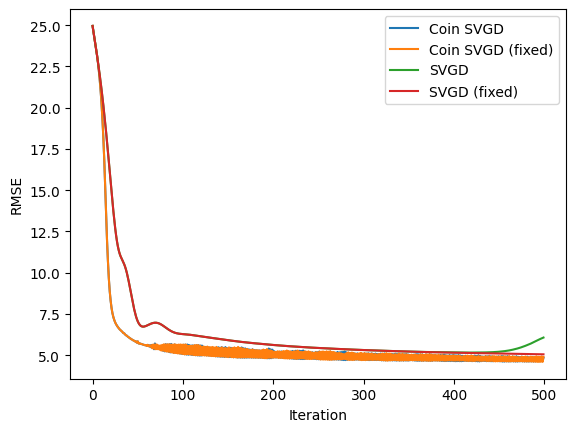

In [76]:
def rmse_trace(particles):
    return vmap(lambda x_hat: jnp.sqrt(jnp.mean((y_test - vmap(lambda x: learn.predict(x, X_test))(x_hat).mean(0)) ** 2)))(particles)

plt.plot(rmse_trace(x_coin), label="Coin SVGD")
plt.plot(rmse_trace(x_coin_fixed), label="Coin SVGD (fixed)")
#plt.plot(rmse_trace(x_pgd), label="PGD")
#plt.plot(rmse_trace(x_pgd_fixed), label="PGD (fixed)")
plt.plot(rmse_trace(x_adam), label="SVGD")
plt.plot(rmse_trace(x_adam_fixed), label="SVGD (fixed)")
# plt.plot(rmse_trace(x_soul), label="Soul")
# plt.xlim(800, 1000)
# plt.ylim(2, 5)

plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend()

In [85]:
from coinem.zoo import coin_svgd, pgd, soul, adam_svgd

import jax.random as jr
from jax import vmap

# Random seeds for reproducibility:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Learning rates:
theta_step_sizes = jnp.logspace(-10, 20, num=20)
latent_step_sizes = jnp.logspace(-10, 20, num=20)

K = 500  # Number of steps.
N = 10  # Number of particles.

coin_errors = []
adam_errors = []
pgd_errors = []
soul_errors = []

coin_lppd = []
adam_lppd = []
pgd_lppd = []
soul_lppd = []

model = learn

for seed in seeds:
    

    X_train, y_train, X_test, y_test = process_data(Boston(), seed)
    data = Dataset(X_train, y_train)

    def rmse_trace(particles):
        return vmap(lambda x_hat: jnp.sqrt(jnp.mean((y_test - vmap(lambda x: learn.predict(x, X_test))(x_hat).mean(0)) ** 2)))(particles)[-1]


    key = jr.PRNGKey(seed)

    key, subkey = jr.split(key)


    th0 = theta
    X0 = latent

    x_coin, th_coin  = coin_svgd(model, data, X0, th0, K, alpha=100.0)

    coin_errors.append(test_error(x_coin))


    for theta_step, latent_step in zip(theta_step_sizes, latent_step_sizes):

        key_pgd, key_soul = jr.split(key)

        x_adam, th_adam = adam_svgd(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step)
        X_pgd, th_pgd = pgd(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_pgd)
        X_soul, th_soul = soul(model, data, X0, th0, K, theta_step_size=theta_step, latent_step_size=latent_step, key=key_soul)
        

        adam_errors.append(test_error(x_adam))
        pgd_errors.append(test_error(X_pgd))
        soul_errors.append(test_error(X_soul))


# Reshape results:
coin_errors = jnp.array(coin_errors)
adam_errors = jnp.array(adam_errors).reshape(-1, theta_step_sizes.shape[0])
pgd_errors = jnp.array(pgd_errors).reshape(-1, theta_step_sizes.shape[0])
soul_errors = jnp.array(soul_errors).reshape(-1, theta_step_sizes.shape[0])


In [88]:
adam_errors

Array([[2.5724085e+01, 2.5724037e+01, 2.5721508e+01, 2.5626999e+01,
        2.1002047e+01, 4.5308685e+00, 2.6085979e+01, 4.4958897e+05,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan],
       [2.4537878e+01, 2.4537828e+01, 2.4535400e+01, 2.4444290e+01,
        2.0100868e+01, 3.3354979e+00, 2.4972534e+01, 4.5897259e+05,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan],
       [2.3944988e+01, 2.3944937e+01, 2.3942406e+01, 2.3847670e+01,
        1.9055056e+01, 3.0218687e+00, 2.4327919e+01, 4.3474559e+05,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,         

(0.0, 50.0)

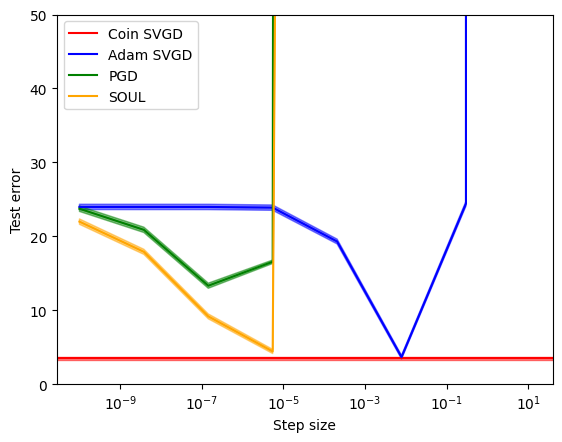

In [91]:
plt.axhline(coin_errors.mean(), color='r', label='Coin SVGD')
plt.axhspan(coin_errors.mean() - coin_errors.std()/jnp.sqrt(10), coin_errors.mean() + coin_errors.std()/jnp.sqrt(10), alpha=0.5, color='r')

plt.plot(theta_step_sizes, adam_errors.mean(0), label='Adam SVGD', color='b')
plt.fill_between(theta_step_sizes, adam_errors.mean(0) - adam_errors.std(0)/jnp.sqrt(10), adam_errors.mean(0) + adam_errors.std(0)/jnp.sqrt(10), alpha=0.5, color='b')

plt.plot(theta_step_sizes, pgd_errors.mean(0), label='PGD', color='g')
plt.fill_between(theta_step_sizes, pgd_errors.mean(0) - pgd_errors.std(0)/jnp.sqrt(10), pgd_errors.mean(0) + pgd_errors.std(0)/jnp.sqrt(10), alpha=0.5 , color='g')


plt.plot(theta_step_sizes, soul_errors.mean(0), label='SOUL' , color='orange')
plt.fill_between(theta_step_sizes, soul_errors.mean(0) - soul_errors.std(0)/jnp.sqrt(10), soul_errors.mean(0) + soul_errors.std(0)/jnp.sqrt(10), alpha=0.5 , color='orange')
plt.xscale('log')
plt.xlabel('Step size')
plt.ylabel('Test error')
plt.legend()
plt.ylim(0, 50)
#plt.savefig('figs/logistic_regression_a.pdf')